# Predicting Amazon review  ratings using Logistic Regression and reducing the dimensionality of the TF-IDF vectors using SVC

After conducting a Logistic Regression model on TF-IDF vectors, I will try to reduce the dimensionality in this exercise without reducing the model performance.

I will begin importing the libraries necessary to perform this exercise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

from functions.nlp import cleaning_review
from functions.preproc import tfidf,var_svc,svc_dimred

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ordovas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ordovas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


As in the simple logistic regression approach, I will load a subset of the database (stored in a MongoDB collection). In this case, I will load the same number of reviews for each rating to balance the classes.

In [2]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset, selecting only a few records 
# (we will use only overall and reviewTest, but I will load a few more just in case I
# want to play with more info...)
df=pd.DataFrame()
for i in range(1,6):
    res = list(books.aggregate([{"$match":{"overall":i}},
        { "$sample": { "size": 10000 }},
        { "$project": {"id": "$_id", "_id": 0, "overall": 1, "reviewText": 1,"summary":1,"reviewerName":1}} ]))
    # Converting to pandas DataFrame
    dft=pd.DataFrame(res)

    dft=dft.dropna().reset_index()
    df=df.append(dft)

df=df.reset_index()
df["overall"].value_counts()

2    10000
4     9999
3     9998
1     9998
5     9992
Name: overall, dtype: int64

I will apply the cleaning function in order to lemmatize the text, remove stopwords and punctuation, and store the cleaned text in `review_clean`.

In [3]:
df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)

Then I will divide the sample in train and test samples, and then I will create a matrix with the TF-IDF vectors for each review (preventing data leakage). I only included words that appear in at least 5 reviews.

In [4]:
Xraw_train, Xraw_test, y_train, y_test = train_test_split(df["review_clean"], df["overall"], test_size=0.15, random_state=42)

Xtfidf_train , Xtfidf_test= tfidf(Xraw_train, Xraw_test,5)

## Reducing the dimensionality using SVC

Now I will test how results change if I reduce the dimensionality of the TF-IDF vectors. I cannot use PCA because the number of features is very large. Instead, I will reduce the dimensionality using the *Truncated SVD* method.

In order to explore how this works, I will search the number of components necessary to include at least 80% of the variance.

The training of the Truncated SVC is conducted using only the train sample, in order to prevent data leakage.

In [5]:
comps,var,svd_transformer = var_svc(Xtfidf_train,step=250,ini_nc=3000)

Nº comp=3000  =>  Var. ratio=0.7824578762533602
Nº comp=3250  =>  Var. ratio=0.7981690110468671
Nº comp=3500  =>  Var. ratio=0.812456907937528


In [6]:
X_train = svd_transformer.transform(Xtfidf_train)
X_test = svd_transformer.transform(Xtfidf_test)

In [7]:
X_train.shape

(42488, 3500)

With this method we reduce the number of features from ~20,000 to 3500, including ~80% of the variance of the initial dataset.

Now let's apply the Logistic Regression to the SVD vectors and check the performance of the prediction model using this approach...

In [8]:
clf = LogisticRegression(random_state=0,class_weight="balanced",max_iter=5000).fit(X_train, y_train)
sc_train=clf.score(X_train, y_train)
sc_test=clf.score(X_test, y_test)
print(f"Train sample classification score: {round(sc_train,2)}")
print(f"Test sample classification score: {round(sc_test,2)}")

Train sample classification score: 0.6
Test sample classification score: 0.5


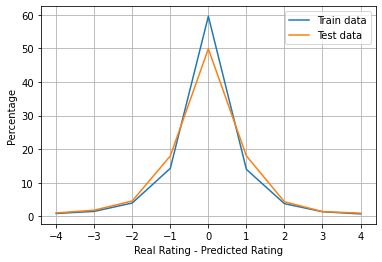

In [9]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.xlabel("Real Rating - Predicted Rating")
plt.ylabel("Percentage")
plt.legend();

Train subsample:


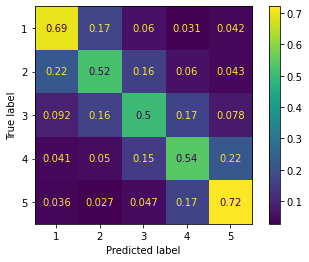

Test subsample:


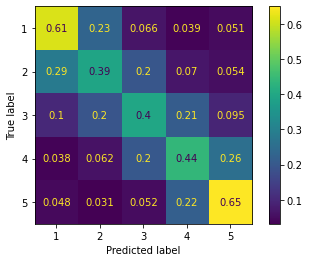

In [10]:
print("Train subsample:")
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

Well, the results using only the 3500 features using Truncated SVD are similar to the ones using the ~20,000 TF-IDF dimensions.

Still, the differences between the train and test datasets indicate that there is some overfitting, so maybe we don't need the 80% of the variance, and we can reduce even more the dimensionality of this exercise.

I will try to check this varying the number of dimensions, perform the Logistic Regression and obtain the scores of each selected number:

In [11]:
nsamples = [10,50,100]+list(range(500,2250,250))

In [12]:
var_vec=[]
v_sc_train=[]
v_sc_test=[]
for nc in nsamples:
    print("Number of dimensions: ",nc)
    comps,var,svd_transformer = svc_dimred(Xtfidf_train,nc)
    var_vec.append(var)
    X_train = svd_transformer.transform(Xtfidf_train)
    X_test = svd_transformer.transform(Xtfidf_test)
    clf = LogisticRegression(random_state=0,class_weight="balanced",max_iter=5000).fit(X_train, y_train)
    v_sc_train.append(clf.score(X_train, y_train))
    v_sc_test.append(clf.score(X_test, y_test))
    print(f"Variance={var} ,Train score={v_sc_train[-1]},Test score={v_sc_test[-1]}")

Number of dimensions:  10
Variance=0.049011740705336496 ,Train score=0.3409668612314065,Test score=0.34471262835044675
Number of dimensions:  50
Variance=0.1304033206990743 ,Train score=0.4272029749576351,Test score=0.43059074543272435
Number of dimensions:  100
Variance=0.18949112125959566 ,Train score=0.4558463566183393,Test score=0.4619282571009468
Number of dimensions:  500
Variance=0.4200154454239682 ,Train score=0.5065430239126342,Test score=0.48459794639285236
Number of dimensions:  750
Variance=0.49691039672062515 ,Train score=0.5215825644887968,Test score=0.4924656620882784
Number of dimensions:  1000
Variance=0.5543822951804016 ,Train score=0.5309028431557146,Test score=0.49166555540738766
Number of dimensions:  1250
Variance=0.6007343688859368 ,Train score=0.5417765016004519,Test score=0.4945992799039872
Number of dimensions:  1500
Variance=0.6392138672250741 ,Train score=0.5494021841461119,Test score=0.49686624883317776
Number of dimensions:  1750
Variance=0.671742665290896

We can visualize it better using a plot. We see that the "sweet spot" is roughly at 500.

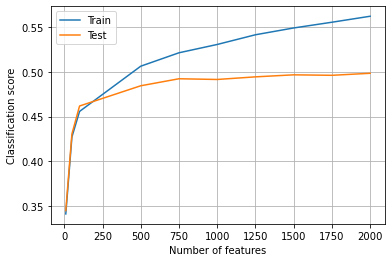

In [13]:
plt.plot(nsamples,v_sc_train,label="Train")
plt.plot(nsamples,v_sc_test,label="Test")
plt.grid()
plt.legend()
plt.xlabel("Number of features")
plt.ylabel("Classification score")
plt.show();

Now I will create a Logistic Regression model using only the 500 dimensions that encapsulates the ~43% of the variance and obtain check its reliability.

In [14]:
comps,var,svd_transformer = svc_dimred(Xtfidf_train,500)
X_train = svd_transformer.transform(Xtfidf_train)
X_test = svd_transformer.transform(Xtfidf_test)
clf = LogisticRegression(random_state=0,class_weight="balanced",max_iter=5000).fit(X_train, y_train)

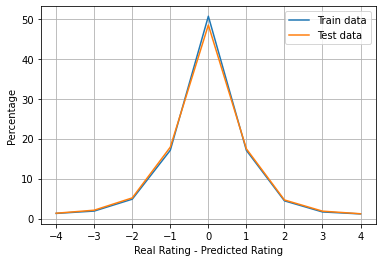

In [15]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.xlabel("Real Rating - Predicted Rating")
plt.ylabel("Percentage")
plt.legend();

Train subsample:


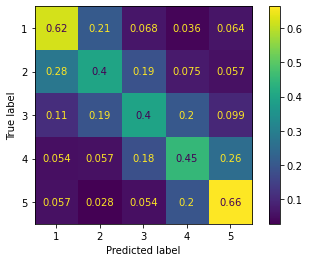

Test subsample:


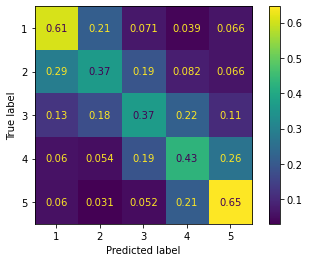

In [16]:
print("Train subsample:")
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

We can see that the test results are equivalent to the previous approaches, and the performance in the train sample is the same as in the test sample. Hence we can reduce the dimensions of this exercise from ~20,000 to 500 avoiding overfitting and obtaining a similar performance predicting the reviews numeric ratings.